# Example 4: Symbolic Regression

The symbolic space is very dense, which means getting the correct symbolic formula (if existing at all) is a hard task. We will show how sentitive symbolic regression is, especially in the presence of noise. This is good or bad:

**Good**: One can easily find symbolic formulas that match with data quite well (within some tolerable epsilon). When one does not care about the exact symbolic formula, they might be happy with these approximate symbolic formulas that fit their data well. These approximate symbolic formulas provide some level of insight, have predictive power and are easy to compute.

**Bad**: It's hard to find the exact formula. When one does care about the exact formula, we either care about (i) its generalizability in future cases (like Newton's gravity), or (ii) fitting the clean data or solving a PDE as precise as machine precision. For case (i), it is open-ended and requires case-by-case analysis. For case (ii), we can get a (hopefully) clear signal of the correctness of a symbolic formula by noticing the loss to go down to near machine precision. We will use an example to demonstrate this below.

## Part I: Automated vs manual symbolic regression (How can we know that we get the exact formula?)

In [20]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [21]:
# train the model
model.train(dataset, opt="LBFGS", steps=40, lamb=0.01, lamb_entropy=10.);

train loss: 1.18e-01 | test loss: 1.24e-01 | reg: 2.69e+01 : 100%|██| 40/40 [00:14<00:00,  2.78it/s]


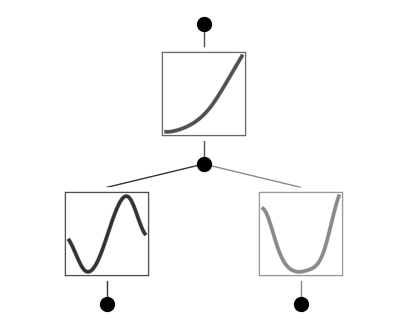

In [22]:
model = model.prune(threshold=1e-1)
model(dataset['train_input'])
model.plot()

In [23]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
sin , 0.9975056052207947
gaussian , 0.9349910020828247
tanh , 0.8612139225006104
sigmoid , 0.8579477667808533
arctan , 0.842193067073822


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9975056052207947)

In [24]:
# x^2 appears in the suggestion list (usually not top 1), but it is fine!
model.suggest_symbolic(0,1,0)

function , r2
cosh , 0.9884885549545288
x^2 , 0.9858922362327576
gaussian , 0.9856787323951721
sin , 0.98312908411026
x^4 , 0.9298607110977173


('cosh',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9884885549545288)

In [25]:
# exp not even appears in the list (but note how high correlation of all these functions), which is sad!
model.suggest_symbolic(1,0,0)

function , r2
sigmoid , 0.9999585151672363
tanh , 0.9999585151672363
gaussian , 0.9999433159828186
arctan , 0.9994633197784424
x^2 , 0.9992135167121887


('sigmoid', (<function kan.utils.<lambda>(x)>, sigmoid), 0.9999585151672363)

In [26]:
# let's try suggesting more by changing topk. Exp should appear in the list
# But it's very unclear why should we prefer exp over others. All of them have quite high correlation with the learned spline.
model.suggest_symbolic(1,0,0,topk=15)

function , r2
sigmoid , 0.9999585151672363
tanh , 0.9999585151672363
gaussian , 0.9999433159828186
arctan , 0.9994633197784424
x^2 , 0.9992135167121887
sin , 0.9992051124572754
cosh , 0.9991425275802612
x^3 , 0.9984820485115051
x^4 , 0.9976401329040527
exp , 0.9952594041824341
1/x^4 , 0.9934328198432922
1/x^3 , 0.9929362535476685
1/x^2 , 0.9920679926872253
1/x , 0.9901971817016602
tan , 0.9887967705726624


('sigmoid', (<function kan.utils.<lambda>(x)>, sigmoid), 0.9999585151672363)

Let's train more! The loss goes down and the splines should be more exact

train loss: 7.30e-03 | test loss: 7.25e-03 | reg: 2.67e+00 : 100%|██| 20/20 [00:02<00:00,  8.11it/s]


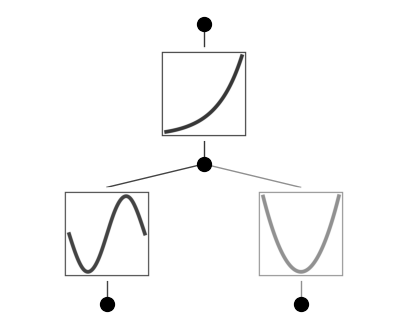

In [27]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [28]:
# sin appears at the top of the suggestion list, which is good!
model.suggest_symbolic(0,0,0)

function , r2
sin , 0.9999734163284302
gaussian , 0.924185574054718
tanh , 0.8712988495826721
sigmoid , 0.8678407073020935
arctan , 0.8526507019996643


('sin',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999734163284302)

In [29]:
# x^2 appears at the top of the suggestion list, which is good!
# But note how competitive cosh and gaussian are. They are also locally quadratic.
model.suggest_symbolic(0,1,0)

function , r2
x^2 , 0.9999990463256836
cosh , 0.9999856352806091
gaussian , 0.9999769926071167
sin , 0.9981749057769775
abs , 0.938005805015564


('x^2',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999990463256836)

In [30]:
# exp appears at the top of the suggestion list, which is good!
model.suggest_symbolic(1,0,0)

function , r2
exp , 0.9999989867210388
cosh , 0.9999958872795105
sigmoid , 0.9999851584434509
tanh , 0.9999068975448608
gaussian , 0.9998790621757507


('exp',
 (<function kan.utils.<lambda>(x)>, <function kan.utils.<lambda>(x)>),
 0.9999989867210388)

The takeaway is that symbolic regression is very sensitive to noise, so if we want to extract exact symbolic formulas from trained networks, the networks need to be trained to quite high accuracy!

In [31]:
# now let's replace every activation function with its top 1 symbolic suggestion. This is implmented in auto_symbolic()
#model.auto_symbolic()

# if the user wants to constrain the symbolic space, they can pass in their symbolic libarary
lib = ['sin', 'x^2', 'exp']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999734163284302
fixing (0,1,0) with x^2, r2=0.9999990463256836
fixing (1,0,0) with exp, r2=0.9999989867210388


After retraining, we get (almost) machine precision! This is the winning signal that this formula is (very likely to be) exact!

train loss: 2.73e-07 | test loss: 2.64e-07 | reg: 2.67e+00 : 100%|██| 20/20 [00:00<00:00, 25.29it/s]


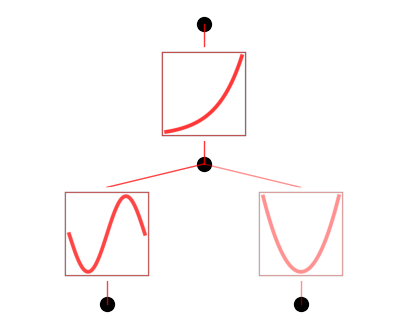

In [32]:
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

In [33]:
# obtaining symbolic formula
formula, variables = model.symbolic_formula()
formula[0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

In [34]:
# if you want to rename your variables, you could use the "var" argument
formula, variables = model.symbolic_formula(var=['\\alpha','y'])
formula[0]

1.0*exp(1.0*y**2 + 1.0*sin(3.14*\alpha))

In [35]:
# one can even postprocess the formula (e.g., taking derivatives)
from sympy import *
diff(formula[0], variables[0])

3.14013671875*exp(1.0*y**2 + 1.0*sin(3.14*\alpha))*cos(3.14*\alpha)

When do we know the formula we guessed is wrong (not exact)? If the data is clean (no noise), we should see the training loss does not reach machine precision

In [36]:
# let's replace (0,1,0) with cosh
model.fix_symbolic(0,1,0,'cosh')

r2 is 0.999990701675415


tensor(1.0000)

train loss: 1.51e-03 | test loss: 1.53e-03 | reg: 2.66e+00 : 100%|██| 20/20 [00:00<00:00, 22.81it/s]


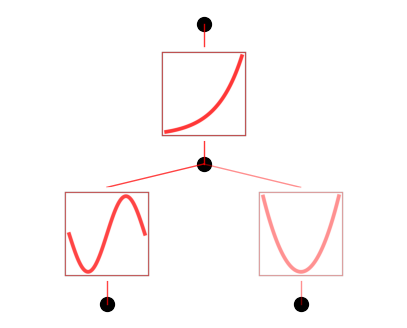

In [37]:
# this loss is stuck at around 1e-3 RMSE, which is good, but not machine precision.
model.train(dataset, opt="LBFGS", steps=20);
model.plot()

## Part II: How hard (ill-defined) is symbolic regression, really?

In part I, we show how people can use KANs for symbolic regression, but caveat that we need to train KANs to quite high precision. This is not a problem specific to KANs though; this issue originates from symbolic regression. The space of symbolic formulas is actually quite dense, so tiny noise can make one symbolic formula transit to another. 

### 1D example: Adding noise to a bounded region sine

In [38]:
def toy(bound=1., noise=0., fun=lambda x: torch.sin(torch.pi*x)):

    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = fun(x) + torch.normal(0,1,size=(num_pts,)) * noise
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=5, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    model.suggest_symbolic(0,0,0)
    model.plot()

train loss: 2.79e-03 | test loss: 2.79e-03 | reg: 3.12e-01 : 100%|██| 20/20 [00:00<00:00, 31.62it/s]


function , r2
sin , 0.9999845623970032
gaussian , 0.9184407591819763
tanh , 0.863538384437561
sigmoid , 0.8601323366165161
arctan , 0.845004141330719


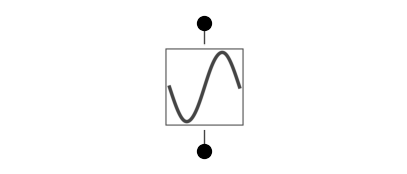

In [39]:
# when the function is whole range "bound=1."" (captures a whole period of sine) and has zero noise "noise=0."
# it is quite clear the function is clear
toy()

train loss: 9.22e-01 | test loss: 9.22e-01 | reg: 3.12e-01 : 100%|██| 20/20 [00:00<00:00, 34.87it/s]


function , r2
sin , 0.9999845623970032
gaussian , 0.9184520840644836
tanh , 0.8635512590408325
sigmoid , 0.8601468205451965
arctan , 0.8450186848640442


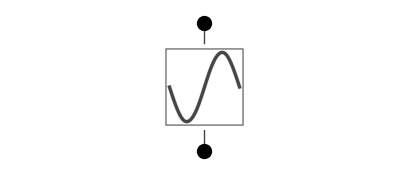

In [40]:
# even with large noise, sine can be revealed, yeah!
toy(noise=1.)

train loss: 9.22e-02 | test loss: 9.22e-02 | reg: 7.15e-01 : 100%|██| 20/20 [00:00<00:00, 47.72it/s]


function , r2
sin , 0.9999920129776001
arctan , 0.9999851584434509
tanh , 0.999984860420227
x^4 , 0.9999810457229614
x^3 , 0.9999809861183167


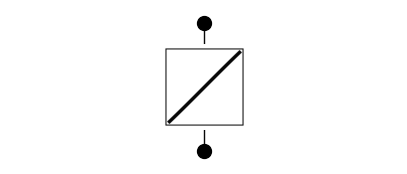

In [41]:
# but when bound is small and there is noise, it starts to screw up (at least becomes less clear why we should prefer sine)
toy(bound = 0.1, noise=0.1)

### Phase diagram of symbolic regression (how fratcal/chaotic is my phase diagram?)

#### mix three functions $f_1(x)={\rm sin}(x)$, $f_2(x)=x^2$, and $f_3(x)={\rm exp}(x)$ such that $f(x)=af_1(x)+bf_2(x)+(1-a-b)f_3(x)$. Symbolically regress $f(x)$.

In [42]:
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0)[0]
    

In [43]:
mix(a=0.2, b=0.0)

train loss: 2.41e-06 | test loss: 2.41e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 39.64it/s]


function , r2
cosh , 0.9999979138374329
exp , 0.9999955296516418
sigmoid , 0.9999611377716064
tanh , 0.9999526143074036
1/x^4 , 0.9999521970748901


'cosh'

: 

In [44]:
# let's do a phase diagram, which looks quite "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b)

train loss: 2.76e-06 | test loss: 2.76e-06 | reg: 2.72e-01 : 100%|██| 20/20 [00:00<00:00, 42.90it/s]


function , r2
exp , 1.0000004768371582
cosh , 1.0000003576278687
tanh , 0.9999734163284302
sigmoid , 0.9999500513076782
1/x^4 , 0.9999372959136963


train loss: 2.53e-06 | test loss: 2.53e-06 | reg: 2.45e-01 : 100%|██| 20/20 [00:00<00:00, 47.69it/s]


function , r2
cosh , 0.9999992251396179
x^4 , 0.9999915957450867
gaussian , 0.9999678134918213
tanh , 0.9999523162841797
sigmoid , 0.9999489784240723


train loss: 2.29e-06 | test loss: 2.29e-06 | reg: 2.18e-01 : 100%|██| 20/20 [00:00<00:00, 38.82it/s]


function , r2
cosh , 0.9999951124191284
x^3 , 0.9999169111251831
gaussian , 0.9997472167015076
x^4 , 0.9996082186698914
tanh , 0.9995840191841125


train loss: 2.05e-06 | test loss: 2.05e-06 | reg: 1.94e-01 : 100%|██| 20/20 [00:00<00:00, 29.49it/s]


function , r2
cosh , 0.9999857544898987
x^3 , 0.9988142848014832
gaussian , 0.9985230565071106
x^2 , 0.99847811460495
sin , 0.9981949925422668


train loss: 1.81e-06 | test loss: 1.81e-06 | reg: 1.71e-01 : 100%|██| 20/20 [00:00<00:00, 36.75it/s]


function , r2
cosh , 0.9999663829803467
x^2 , 0.9986101984977722
sin , 0.9982841610908508
x^3 , 0.9936587810516357
gaussian , 0.9936466217041016


train loss: 1.55e-06 | test loss: 1.55e-06 | reg: 1.51e-01 : 100%|██| 20/20 [00:00<00:00, 38.42it/s]


function , r2
cosh , 0.9999421834945679
x^2 , 0.9987948536872864
sin , 0.9984332323074341
gaussian , 0.994968831539154
tanh , 0.9764367938041687


train loss: 1.31e-06 | test loss: 1.31e-06 | reg: 1.37e-01 : 100%|██| 20/20 [00:00<00:00, 39.66it/s]


function , r2
cosh , 0.9999043941497803
x^2 , 0.9990440011024475
sin , 0.9986633658409119
gaussian , 0.995881199836731
tanh , 0.9380274415016174


train loss: 1.07e-06 | test loss: 1.07e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 39.32it/s]


function , r2
cosh , 0.9998658895492554
x^2 , 0.9993508458137512
sin , 0.9989811182022095
gaussian , 0.991625964641571
x^4 , 0.9172568321228027


train loss: 8.33e-07 | test loss: 8.33e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:00<00:00, 41.60it/s]


function , r2
x^2 , 0.9996704459190369
sin , 0.9993890523910522
cosh , 0.9985612034797668
gaussian , 0.9707186818122864
abs , 0.9254010915756226


train loss: 6.06e-07 | test loss: 6.06e-07 | reg: 1.30e-01 : 100%|██| 20/20 [00:00<00:00, 38.87it/s]


function , r2
x^2 , 0.9999135732650757
sin , 0.9994936585426331
gaussian , 0.9994853734970093
cosh , 0.9879138469696045
abs , 0.9339755177497864


train loss: 3.80e-07 | test loss: 3.80e-07 | reg: 1.38e-01 : 100%|██| 20/20 [00:00<00:00, 37.53it/s]


function , r2
x^2 , 1.0000004768371582
cosh , 0.9999102354049683
gaussian , 0.9997107982635498
sin , 0.9989291429519653
abs , 0.9374392032623291


train loss: 2.58e-06 | test loss: 2.58e-06 | reg: 2.68e-01 : 100%|██| 20/20 [00:00<00:00, 41.10it/s]


function , r2
exp , 0.999999463558197
arctan , 0.9999802708625793
cosh , 0.9999773502349854
tanh , 0.9999637007713318
sigmoid , 0.9999545216560364


train loss: 2.34e-06 | test loss: 2.34e-06 | reg: 2.40e-01 : 100%|██| 20/20 [00:00<00:00, 39.00it/s]


function , r2
cosh , 0.9999938011169434
x^4 , 0.9999866485595703
gaussian , 0.9999640583992004
sigmoid , 0.9999451041221619
x^3 , 0.9999441504478455


train loss: 2.10e-06 | test loss: 2.10e-06 | reg: 2.14e-01 : 100%|██| 20/20 [00:00<00:00, 38.52it/s]


function , r2
cosh , 0.9999948740005493
x^3 , 0.999884843826294
gaussian , 0.9997602105140686
tanh , 0.9996165633201599
sigmoid , 0.9996150135993958


train loss: 1.86e-06 | test loss: 1.86e-06 | reg: 1.89e-01 : 100%|██| 20/20 [00:00<00:00, 35.26it/s]


function , r2
cosh , 0.9999828934669495
x^2 , 0.9991239309310913
sin , 0.9988862872123718
x^3 , 0.9987776279449463
gaussian , 0.9986570477485657


train loss: 1.61e-06 | test loss: 1.61e-06 | reg: 1.66e-01 : 100%|██| 20/20 [00:00<00:00, 42.30it/s]


function , r2
cosh , 0.9999908804893494
x^2 , 0.9992858171463013
sin , 0.9988725185394287
gaussian , 0.9985800385475159
x^3 , 0.9939917325973511


train loss: 1.38e-06 | test loss: 1.38e-06 | reg: 1.45e-01 : 100%|██| 20/20 [00:00<00:00, 43.74it/s]


function , r2
cosh , 0.9999798536300659
x^2 , 0.9994809031486511
sin , 0.9991909861564636
gaussian , 0.9964683651924133
tanh , 0.9772538542747498


train loss: 1.13e-06 | test loss: 1.13e-06 | reg: 1.29e-01 : 100%|██| 20/20 [00:00<00:00, 38.78it/s]


function , r2
cosh , 0.9999741315841675
x^2 , 0.999697744846344
sin , 0.9994117617607117
gaussian , 0.9973545074462891
tanh , 0.9376919269561768


train loss: 8.83e-07 | test loss: 8.83e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 33.35it/s]


function , r2
x^2 , 0.9998961091041565
cosh , 0.9998720288276672
sin , 0.9996592402458191
gaussian , 0.9939866662025452
abs , 0.923265278339386


train loss: 6.52e-07 | test loss: 6.52e-07 | reg: 1.20e-01 : 100%|██| 20/20 [00:00<00:00, 36.61it/s]


function , r2
x^2 , 0.9999977350234985
sin , 0.9998341798782349
cosh , 0.9962064027786255
gaussian , 0.9754126071929932
abs , 0.9311625957489014


train loss: 4.24e-07 | test loss: 4.24e-07 | reg: 1.24e-01 : 100%|██| 20/20 [00:00<00:00, 32.89it/s]


function , r2
x^2 , 0.9999229311943054
sin , 0.9998641014099121
cosh , 0.9997752904891968
gaussian , 0.9996799826622009
abs , 0.9372400641441345


train loss: 2.30e-07 | test loss: 2.30e-07 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 41.67it/s]


function , r2
cosh , 0.9995552897453308
gaussian , 0.999346911907196
sin , 0.9985870718955994
x^2 , 0.9984340071678162
abs , 0.9362897276878357


train loss: 2.41e-06 | test loss: 2.41e-06 | reg: 2.64e-01 : 100%|██| 20/20 [00:00<00:00, 40.92it/s]


function , r2
cosh , 0.9999979138374329
exp , 0.9999955296516418
sigmoid , 0.9999611377716064
tanh , 0.9999526143074036
1/x^4 , 0.9999521970748901


train loss: 2.17e-06 | test loss: 2.17e-06 | reg: 2.36e-01 : 100%|██| 20/20 [00:00<00:00, 41.94it/s]


function , r2
cosh , 0.9999991655349731
x^3 , 0.9999775886535645
x^4 , 0.999970018863678
gaussian , 0.9999597072601318
sigmoid , 0.9999392032623291


train loss: 1.93e-06 | test loss: 1.93e-06 | reg: 2.09e-01 : 100%|██| 20/20 [00:00<00:00, 38.44it/s]


function , r2
cosh , 0.9999996423721313
x^3 , 0.9998223185539246
gaussian , 0.9997662901878357
tanh , 0.999638557434082
sigmoid , 0.9996371269226074


train loss: 1.69e-06 | test loss: 1.69e-06 | reg: 1.84e-01 : 100%|██| 20/20 [00:00<00:00, 32.51it/s]


function , r2
cosh , 0.9999992847442627
x^2 , 0.9996203780174255
sin , 0.9994373917579651
gaussian , 0.998763918876648
x^3 , 0.9986607432365417


train loss: 1.43e-06 | test loss: 1.43e-06 | reg: 1.60e-01 : 100%|██| 20/20 [00:00<00:00, 39.86it/s]


function , r2
cosh , 0.999995768070221
x^2 , 0.9997673630714417
sin , 0.999495804309845
gaussian , 0.9992840886116028
x^3 , 0.9941053986549377


train loss: 1.19e-06 | test loss: 1.19e-06 | reg: 1.39e-01 : 100%|██| 20/20 [00:00<00:00, 36.83it/s]


function , r2
x^2 , 0.9999061226844788
cosh , 0.9997881650924683
sin , 0.9997012615203857
gaussian , 0.9978273510932922
sigmoid , 0.9780414700508118


train loss: 9.43e-07 | test loss: 9.43e-07 | reg: 1.23e-01 : 100%|██| 20/20 [00:00<00:00, 49.94it/s]


function , r2
x^2 , 0.9999920129776001
sin , 0.999854326248169
gaussian , 0.9985647201538086
cosh , 0.9978691339492798
tanh , 0.9372187256813049


train loss: 7.02e-07 | test loss: 7.02e-07 | reg: 1.15e-01 : 100%|██| 20/20 [00:00<00:00, 37.15it/s]


function , r2
x^2 , 0.9999415874481201
sin , 0.9999181628227234
cosh , 0.999316930770874
gaussian , 0.9961109161376953
abs , 0.9302395582199097


train loss: 4.80e-07 | test loss: 4.80e-07 | reg: 1.13e-01 : 100%|██| 20/20 [00:00<00:00, 40.21it/s]


function , r2
sin , 0.9997866153717041
x^2 , 0.9996583461761475
cosh , 0.9942753911018372
gaussian , 0.9798859357833862
abs , 0.936910092830658


train loss: 2.67e-07 | test loss: 2.67e-07 | reg: 1.18e-01 : 100%|██| 20/20 [00:00<00:00, 35.55it/s]


function , r2
sin , 0.9992179274559021
x^2 , 0.999137818813324
gaussian , 0.99908846616745
cosh , 0.9988974928855896
abs , 0.939662754535675


train loss: 1.85e-07 | test loss: 1.85e-07 | reg: 1.27e-01 : 100%|██| 20/20 [00:00<00:00, 39.93it/s]


function , r2
x^2 , 0.9985410571098328
cosh , 0.9984979033470154
sin , 0.9981679916381836
gaussian , 0.9980800747871399
abs , 0.934815526008606


train loss: 2.22e-06 | test loss: 2.22e-06 | reg: 2.60e-01 : 100%|██| 20/20 [00:00<00:00, 41.47it/s]


function , r2
cosh , 0.9999932646751404
exp , 0.9999840259552002
tanh , 0.999982476234436
x^4 , 0.9999751448631287
arctan , 0.999971866607666


train loss: 1.99e-06 | test loss: 1.99e-06 | reg: 2.32e-01 : 100%|██| 20/20 [00:00<00:00, 49.73it/s]


function , r2
cosh , 0.9999966621398926
x^3 , 0.9999815225601196
gaussian , 0.9999538660049438
tanh , 0.9999339580535889
sigmoid , 0.9999309182167053


train loss: 1.74e-06 | test loss: 1.74e-06 | reg: 2.05e-01 : 100%|██| 20/20 [00:00<00:00, 34.40it/s]


function , r2
cosh , 0.999996542930603
x^2 , 0.9998264908790588
gaussian , 0.9997667074203491
x^3 , 0.9997121095657349
sin , 0.9997117519378662


train loss: 1.49e-06 | test loss: 1.49e-06 | reg: 1.79e-01 : 100%|██| 20/20 [00:00<00:00, 45.50it/s]


function , r2
cosh , 0.9999545216560364
x^2 , 0.9999237656593323
sin , 0.9998099207878113
gaussian , 0.9988470077514648
x^3 , 0.9984461069107056


train loss: 1.25e-06 | test loss: 1.25e-06 | reg: 1.55e-01 : 100%|██| 20/20 [00:00<00:00, 38.11it/s]


function , r2
x^2 , 0.9999879002571106
cosh , 0.9999627470970154
sin , 0.999884307384491
gaussian , 0.9997448325157166
x^3 , 0.9939817190170288


train loss: 1.01e-06 | test loss: 1.01e-06 | reg: 1.33e-01 : 100%|██| 20/20 [00:00<00:00, 38.02it/s]


function , r2
x^2 , 0.9999662041664124
sin , 0.9998830556869507
cosh , 0.9991430640220642
gaussian , 0.9988926649093628
tanh , 0.9787979125976562


train loss: 7.72e-07 | test loss: 7.72e-07 | reg: 1.17e-01 : 100%|██| 20/20 [00:00<00:00, 38.39it/s]


function , r2
sin , 0.9999326467514038
x^2 , 0.9997600317001343
cosh , 0.9994867444038391
gaussian , 0.9994862079620361
tanh , 0.9365764260292053


train loss: 5.44e-07 | test loss: 5.44e-07 | reg: 1.08e-01 : 100%|██| 20/20 [00:00<00:00, 37.80it/s]


function , r2
sin , 0.9997549653053284
x^2 , 0.9992306232452393
cosh , 0.9979138970375061
gaussian , 0.997799813747406
abs , 0.9377140402793884


train loss: 3.27e-07 | test loss: 3.27e-07 | reg: 1.07e-01 : 100%|██| 20/20 [00:00<00:00, 33.95it/s]


function , r2
sin , 0.9990792274475098
x^2 , 0.9983073472976685
cosh , 0.9912197589874268
gaussian , 0.9838365316390991
abs , 0.9422998428344727


train loss: 2.87e-07 | test loss: 2.87e-07 | reg: 1.12e-01 : 100%|██| 20/20 [00:00<00:00, 36.86it/s]


function , r2
sin , 0.9974242448806763
gaussian , 0.9973312616348267
x^2 , 0.997200071811676
cosh , 0.9968913197517395
abs , 0.9402046203613281


train loss: 3.09e-07 | test loss: 3.09e-07 | reg: 1.21e-01 : 100%|██| 20/20 [00:00<00:00, 39.14it/s]


function , r2
cosh , 0.9964800477027893
x^2 , 0.9963343739509583
sin , 0.9959864020347595
gaussian , 0.9956439137458801
abs , 0.9297640919685364


train loss: 2.05e-06 | test loss: 2.05e-06 | reg: 2.57e-01 : 100%|██| 20/20 [00:00<00:00, 39.63it/s]


function , r2
x^4 , 0.9999900460243225
x^3 , 0.9999839663505554
tanh , 0.9999814629554749
cosh , 0.9999808073043823
sigmoid , 0.9999732971191406


train loss: 1.80e-06 | test loss: 1.80e-06 | reg: 2.28e-01 : 100%|██| 20/20 [00:00<00:00, 36.95it/s]


function , r2
cosh , 0.999967634677887
gaussian , 0.9999465942382812
x^2 , 0.9999383091926575
x^3 , 0.9999352693557739
tanh , 0.9999257326126099


train loss: 1.57e-06 | test loss: 1.57e-06 | reg: 2.00e-01 : 100%|██| 20/20 [00:00<00:00, 39.61it/s]


function , r2
x^2 , 0.9999861717224121
cosh , 0.9999809265136719
sin , 0.9999337196350098
gaussian , 0.9997633695602417
tanh , 0.9996618628501892


train loss: 1.31e-06 | test loss: 1.31e-06 | reg: 1.74e-01 : 100%|██| 20/20 [00:00<00:00, 43.85it/s]


function , r2
x^2 , 0.9999807476997375
sin , 0.9999692440032959
cosh , 0.9996538162231445
gaussian , 0.9989100694656372
tanh , 0.9985538721084595


train loss: 1.08e-06 | test loss: 1.08e-06 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 44.67it/s]


function , r2
sin , 0.9999731183052063
gaussian , 0.9999253749847412
x^2 , 0.9998627305030823
cosh , 0.9996562600135803
tanh , 0.9942789673805237


train loss: 8.36e-07 | test loss: 8.36e-07 | reg: 1.28e-01 : 100%|██| 20/20 [00:00<00:00, 37.37it/s]


function , r2
sin , 0.9999428391456604
gaussian , 0.9999094009399414
x^2 , 0.9995195269584656
cosh , 0.9978922009468079
tanh , 0.9795185327529907


train loss: 6.02e-07 | test loss: 6.02e-07 | reg: 1.10e-01 : 100%|██| 20/20 [00:00<00:00, 37.56it/s]


function , r2
sin , 0.9998138546943665
gaussian , 0.9997873902320862
x^2 , 0.998761773109436
cosh , 0.9982634782791138
abs , 0.9422873854637146


train loss: 3.95e-07 | test loss: 3.95e-07 | reg: 1.02e-01 : 100%|██| 20/20 [00:00<00:00, 38.63it/s]


function , r2
sin , 0.9992998242378235
gaussian , 0.9987375736236572
x^2 , 0.9973756670951843
cosh , 0.9952549338340759
abs , 0.945526123046875


train loss: 2.41e-07 | test loss: 2.41e-07 | reg: 1.00e-01 : 100%|██| 20/20 [00:00<00:00, 39.00it/s]


function , r2
sin , 0.9974730014801025
x^2 , 0.99542236328125
gaussian , 0.9867520928382874
cosh , 0.986582338809967
abs , 0.946847677230835


train loss: 2.99e-07 | test loss: 2.99e-07 | reg: 1.05e-01 : 100%|██| 20/20 [00:00<00:00, 42.52it/s]


function , r2
sin , 0.9938674569129944
gaussian , 0.9937912821769714
x^2 , 0.9936060905456543
cosh , 0.9932430982589722
abs , 0.9381967186927795


train loss: 4.70e-07 | test loss: 4.70e-07 | reg: 1.16e-01 : 100%|██| 20/20 [00:00<00:00, 37.83it/s]


function , r2
x^2 , 0.992730975151062
sin , 0.9922831058502197
gaussian , 0.9916990995407104
cosh , 0.9856394529342651
abs , 0.9212248921394348


train loss: 1.86e-06 | test loss: 1.86e-06 | reg: 2.53e-01 : 100%|██| 20/20 [00:00<00:00, 48.54it/s]


function , r2
cosh , 0.9999890923500061
x^2 , 0.99998539686203
tanh , 0.9999764561653137
x^3 , 0.9999762773513794
sigmoid , 0.9999720454216003


train loss: 1.62e-06 | test loss: 1.62e-06 | reg: 2.24e-01 : 100%|██| 20/20 [00:00<00:00, 36.49it/s]


function , r2
x^2 , 0.9999876022338867
sin , 0.9999815225601196
cosh , 0.999955415725708
gaussian , 0.9999386668205261
tanh , 0.9999181628227234


train loss: 1.39e-06 | test loss: 1.39e-06 | reg: 1.96e-01 : 100%|██| 20/20 [00:00<00:00, 38.88it/s]


function , r2
sin , 0.9999863505363464
gaussian , 0.9999647736549377
x^2 , 0.9999219179153442
tanh , 0.9996707439422607
sigmoid , 0.9996693134307861


train loss: 1.16e-06 | test loss: 1.16e-06 | reg: 1.69e-01 : 100%|██| 20/20 [00:00<00:00, 46.42it/s]


function , r2
sin , 0.9999806880950928
x^2 , 0.9997264742851257
cosh , 0.9993475079536438
gaussian , 0.998957633972168
tanh , 0.9986547827720642


train loss: 9.09e-07 | test loss: 9.09e-07 | reg: 1.44e-01 : 100%|██| 20/20 [00:00<00:00, 42.03it/s]


function , r2
sin , 0.9999589323997498
gaussian , 0.999949038028717
x^2 , 0.9992832541465759
cosh , 0.9988743662834167
tanh , 0.9946618676185608


train loss: 6.76e-07 | test loss: 6.76e-07 | reg: 1.22e-01 : 100%|██| 20/20 [00:00<00:00, 38.80it/s]


function , r2
sin , 0.9998827576637268
gaussian , 0.9998784065246582
x^2 , 0.9983744621276855
cosh , 0.9979462027549744
tanh , 0.9802091121673584


train loss: 4.66e-07 | test loss: 4.66e-07 | reg: 1.04e-01 : 100%|██| 20/20 [00:00<00:00, 43.31it/s]


function , r2
gaussian , 0.9995979070663452
sin , 0.99959397315979
x^2 , 0.9966496229171753
cosh , 0.9958799481391907
abs , 0.951285183429718


train loss: 3.07e-07 | test loss: 3.07e-07 | reg: 9.48e-02 : 100%|██| 20/20 [00:00<00:00, 36.47it/s]


function , r2
sin , 0.9984510540962219
gaussian , 0.9959579110145569
x^2 , 0.9937822222709656
cosh , 0.9907205104827881
abs , 0.953465461730957


train loss: 3.02e-07 | test loss: 3.02e-07 | reg: 9.38e-02 : 100%|██| 20/20 [00:00<00:00, 38.52it/s]


function , r2
sin , 0.9943904280662537
x^2 , 0.990205705165863
gaussian , 0.9877625703811646
cosh , 0.976122260093689
abs , 0.9497421979904175


train loss: 4.48e-07 | test loss: 4.48e-07 | reg: 9.92e-02 : 100%|██| 20/20 [00:00<00:00, 38.11it/s]


function , r2
x^2 , 0.9876754879951477
gaussian , 0.9876450896263123
sin , 0.9874566197395325
cosh , 0.9873764514923096
abs , 0.9320315718650818


train loss: 6.46e-07 | test loss: 6.46e-07 | reg: 1.11e-01 : 100%|██| 20/20 [00:00<00:00, 50.00it/s]


function , r2
x^2 , 0.9873684644699097
sin , 0.9867106080055237
cosh , 0.9863604307174683
gaussian , 0.985936164855957
x^4 , 0.9239131808280945


train loss: 1.69e-06 | test loss: 1.69e-06 | reg: 2.50e-01 : 100%|██| 20/20 [00:00<00:00, 31.83it/s]


function , r2
sin , 0.9999911785125732
tanh , 0.9999727010726929
sigmoid , 0.9999706745147705
gaussian , 0.9999555945396423
x^2 , 0.9999528527259827


train loss: 1.45e-06 | test loss: 1.45e-06 | reg: 2.20e-01 : 100%|██| 20/20 [00:00<00:00, 38.30it/s]


function , r2
sin , 0.9999904036521912
gaussian , 0.9999315142631531
tanh , 0.9999148845672607
sigmoid , 0.9999133944511414
x^2 , 0.9998382329940796


train loss: 1.21e-06 | test loss: 1.21e-06 | reg: 1.92e-01 : 100%|██| 20/20 [00:00<00:00, 41.34it/s]


function , r2
sin , 0.9999865889549255
gaussian , 0.9997520446777344
tanh , 0.9996843934059143
sigmoid , 0.9996832609176636
x^2 , 0.9995861649513245


train loss: 9.75e-07 | test loss: 9.75e-07 | reg: 1.65e-01 :  65%|█▎| 13/20 [00:00<00:00, 40.90it/s]

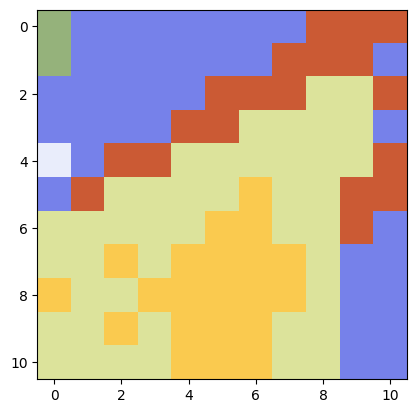

In [ ]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]
    

img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)

Does this mean symbolic regression is screwed? The hope is that by incorporating reasonable inductive biases (hence reducing the symbolic search space), SR will become more robust.

In [ ]:
# we have used the default symbolic library whch contains the following functions
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', '1/x', '1/x^2', '1/x^3', '1/x^4', 'sqrt', '1/sqrt(x)', 'exp', 'log', 'abs', 'sin', 'tan', 'tanh', 'sigmoid', 'sgn', 'arcsin', 'arctan', 'arctanh', '0', 'gaussian', 'cosh'])

In [ ]:
# we may constrain to a smaller library (pass as parameter "lib=lib" in suggest_symbolic)
lib = ['exp', 'x^2', 'sin']
def mix(a, b, bound=1):
    num_pts = 101
    x = torch.linspace(-bound,bound,steps=num_pts)
    x = x[:,None]
    y = a * torch.sin(x) + b * x**2 + (1-a-b) * torch.exp(x)
    dataset = {}
    dataset['train_input'] = dataset['test_input'] = x
    dataset['train_label'] = dataset['test_label'] = y
    model = KAN(width=[1,1], grid=10, k=3, seed=0, grid_range=(-bound,bound))
    model.train(dataset, opt="LBFGS", steps=20)
    return model.suggest_symbolic(0,0,0,lib=lib)[0]


In [ ]:
# we can redo the analysis for a more contrained (bound) region. The phase diagram becomes even more "fractal"
num = 11
a_arr = np.linspace(0,1,num=num)
b_arr = np.linspace(0,1,num=num)
sf_mat = np.empty((num,num), dtype='U8')

for i in range(num):
    for j in range(num):
        a = a_arr[i]; b = b_arr[j]
        sf_mat[i,j] = mix(a, b, bound=0.3)

train loss: 6.02e-08 | test loss: 6.02e-08 | reg: 2.58e-01 : 100%|██| 20/20 [00:00<00:00, 40.38it/s]


function , r2
exp , 1.0000003576278687
x^2 , 0.9999846816062927
sin , 0.9999200701713562


train loss: 8.53e-08 | test loss: 8.53e-08 | reg: 2.31e-01 : 100%|██| 20/20 [00:00<00:00, 41.41it/s]


function , r2
exp , 0.9999967217445374
x^2 , 0.9999846816062927
sin , 0.999906063079834


train loss: 4.93e-08 | test loss: 4.93e-08 | reg: 2.03e-01 : 100%|██| 20/20 [00:00<00:00, 41.89it/s]


function , r2
x^2 , 0.999984860420227
exp , 0.9999766945838928
sin , 0.9998868703842163


train loss: 5.00e-08 | test loss: 5.00e-08 | reg: 1.77e-01 : 100%|██| 20/20 [00:00<00:00, 43.22it/s]


function , r2
x^2 , 0.9999847412109375
exp , 0.9999104142189026
sin , 0.9998597502708435


train loss: 4.23e-08 | test loss: 4.23e-08 | reg: 1.50e-01 : 100%|██| 20/20 [00:00<00:00, 50.58it/s]


function , r2
x^2 , 0.9999850392341614
sin , 0.9998199343681335
exp , 0.9997116923332214


train loss: 6.63e-08 | test loss: 6.63e-08 | reg: 1.24e-01 : 100%|██| 20/20 [00:03<00:00,  6.14it/s]


function , r2
x^2 , 0.9999852776527405
sin , 0.9997579455375671
exp , 0.9991052150726318


train loss: 3.05e-08 | test loss: 3.05e-08 | reg: 9.83e-02 : 100%|██| 20/20 [00:02<00:00,  9.78it/s]


function , r2
x^2 , 0.999985933303833
sin , 0.9996548891067505
exp , 0.9971045255661011


train loss: 5.92e-08 | test loss: 5.92e-08 | reg: 7.39e-02 : 100%|██| 20/20 [00:02<00:00,  9.02it/s]


function , r2
x^2 , 0.9999871253967285
sin , 0.9994735717773438
exp , 0.989564836025238


train loss: 1.85e-08 | test loss: 1.85e-08 | reg: 5.19e-02 : 100%|██| 20/20 [00:02<00:00,  9.59it/s]


function , r2
x^2 , 0.9999894499778748
sin , 0.9991207718849182
exp , 0.9559776186943054


train loss: 1.79e-08 | test loss: 1.79e-08 | reg: 3.99e-02 : 100%|██| 20/20 [00:02<00:00,  8.76it/s]


function , r2
x^2 , 0.999992847442627
sin , 0.9987168908119202
exp , 0.7906889319419861


train loss: 1.53e-08 | test loss: 1.53e-08 | reg: 3.92e-02 : 100%|██| 20/20 [00:01<00:00, 10.16it/s]


function , r2
x^2 , 0.9999985694885254
sin , 0.9975490570068359
exp , 0.2695852816104889


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

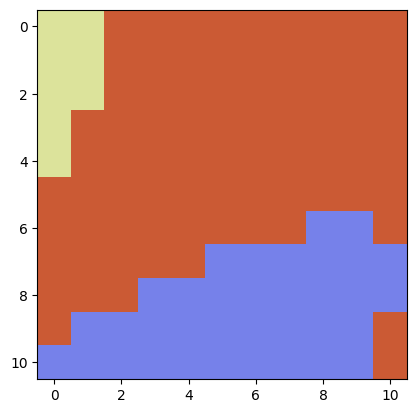

In [ ]:
classes = list(set(sf_mat.reshape(-1,)))
n_class = len(classes)

colors = np.random.rand(n_class,4)
dic = {}
for i in range(n_class):
    dic[classes[i]] = colors[i]
    

img = np.zeros((num,num,4))
for i in range(num):
    for j in range(num):
        img[i][j] = dic[sf_mat[i][j]]
plt.imshow(img)